In [1]:
import numpy as np
import cv2 as cv
import math
from matplotlib import pyplot as plt
import pandas as pd
%matplotlib inline

from matplotlib.pyplot import cm
from PIL import Image, ImageOps

find homography and transformed path

input:
- src_filename - ชื่อไฟล์ src.out จาก Find_dst_src_Homogarphy
- dst_filename - ชื่อไฟล์ dst.out จาก Find_dst_src_Homogarphy
- track_file_path - path ของไฟล์ csv ผลลัพธ์ tracking

output:
- print homography matrix at the end
- transformedTrack.csv - path ที่ transformed แล้ว

In [2]:
#input
src_filename = "dst_src_n/avg5_src_n.out"
dst_filename = "dst_src_n/avg5_dst_n.out"
track_file_path = 'track_result/obj_traj1_full.csv'
output_filename = 'transformedTrack_traj1_p.csv'

#read input
src_list = np.loadtxt(src_filename, delimiter=',')
src_list = src_list.tolist()
dst_list = np.loadtxt(dst_filename, delimiter=',')
dst_list = dst_list.tolist()

In [142]:
def frameTransform(point_list,H):
    transformed_point = []
    transformed_x =[]
    transformed_y =[]
    for n in point_list:
        #***assume point in src_list and trans_list are on the same plane***
        n.append(1)
        p = np.matmul(H, np.array(n).T)
        normalized_point = p / p[-1]
        transformed_point.append(normalized_point)
        transformed_x.append(normalized_point[0])
        transformed_y.append(normalized_point[1])
    return transformed_point,transformed_x,transformed_y

def get_Homography(src_list, dst_list):
    src_pts = np.array(src_list).reshape(-1,1,2)
    dst_pts = np.array(dst_list).reshape(-1,1,2)
    H, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    print("H:")
    print(H)
    #plan_view = cv.warpPerspective(src, H, (2000,2000))
    #return plan_view,H
    return H

def find_CenterPoint(xmin,ymin,xmax,ymax):
    center_x = (xmin + xmax) / 2
    center_y = ymax #แกนyกลับทิศ
    return center_x, center_y

def read_Track(track_file_path):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(track_file_path)

    center_points = []
    frame_list = []
    id_list = []
    class_list = []
    for index, row in df.iterrows():
        frame = row['frame']
        id = row['id']
        det_class = row['class']
        xmin = row['xmin']
        ymin = row['ymin']
        xmax = row['xmax']
        ymax = row['ymax']

        # Calculate the center points
        center_x, center_y = find_CenterPoint(xmin,ymin,xmax,ymax)

        if (xmax-xmin)>15 and (ymax-ymin)>35:
            frame_list.append(frame)
            id_list.append(id)
            class_list.append(det_class)
            center_points.append([center_x, center_y])
            
    return frame_list, id_list, class_list, center_points

def write_csv(frame_list, id_list, transformed_x,transformed_y):
    # Create a pandas DataFrame from the data
    df = pd.DataFrame({
        'frame': frame_list,
        'id': id_list,
        'class': class_list,
        'x': transformed_x,
        'y': transformed_y
    })

    # Write the DataFrame to a CSV file
    df.to_csv(output_filename, index=False)



In [143]:
#Read tracking csv file to list
frame_list, id_list, class_list, trans_list = read_Track(track_file_path)

Hmtx = get_Homography(src_list, dst_list)

#Transform point
transformed_point,transformed_x,transformed_y = frameTransform(trans_list,Hmtx)

#write result to csv
write_csv(frame_list, id_list, transformed_x,transformed_y)

H:
[[ 6.18364083e-02 -2.90241364e-01  2.49735008e+01]
 [ 5.66003293e-02  3.63753306e-01 -1.12329140e+02]
 [-4.26656500e-04  1.13429861e-02  1.00000000e+00]]


## Plot

In [21]:
#input
track_filename = 'track_result/obj_traj2_full.csv'

problem_id_path = 'problem_id2.out'

#read input
problem_id = np.loadtxt(problem_id_path, delimiter=',')
problem_id = problem_id.tolist()

In [22]:
#plot code by ME15

def csv_to_list_id(df,interest_id):
  sort_id = df.sort_values(["id","frame"])
  plotting = [[]]
  max_id = sort_id['id'].max()
  for i in interest_id:
    id1 = sort_id[sort_id["id"] == i]
    id1 = id1.reset_index()
    x_array = []
    y_array = []
    for j in range(0, len(id1)):
      x_center = (id1.iloc[j]['xmin'] + id1.iloc[j]['xmax'])/2
      y_center = id1.iloc[j]['ymax']
      x_array.append(x_center)
      y_array.append(y_center)
    plotting.append([x_array,y_array])
  return plotting

def csv_to_list(df):
  sort_id = df.sort_values(["id","frame"])
  plotting = [[]]
  max_id = sort_id['id'].max()
  for i in range(1, max_id+1):
    id1 = sort_id[sort_id["id"] == i]
    id1 = id1.reset_index()
    x_array = []
    y_array = []
    for j in range(0, len(id1)):
      x_center = (id1.iloc[j]['xmin'] + id1.iloc[j]['xmax'])/2
      y_center = id1.iloc[j]['ymax']
      x_array.append(x_center)
      y_array.append(y_center)
    plotting.append([x_array,y_array])
  return plotting

def csv_to_list_filter(df):
  sort_id = df.sort_values(["id","frame"])
  plotting = [[]]
  max_id = sort_id['id'].max()
  for i in range(1, max_id+1):
    if i not in problem_id:
      id1 = sort_id[sort_id["id"] == i]
      id1 = id1.reset_index()
      x_array = []
      y_array = []
      for j in range(0, len(id1)):
        x_center = (id1.iloc[j]['xmin'] + id1.iloc[j]['xmax'])/2
        y_center = id1.iloc[j]['ymax']
        x_array.append(x_center)
        y_array.append(y_center)
      plotting.append([x_array,y_array])
  return plotting

def traj_plot(plotdata,l):
  color = iter(cm.rainbow(np.linspace(0,1,len(plotdata)+2)))
  bg = Image.open('imgs/asoke_2.jpg')
  plt.imshow(bg,alpha=0.5)
  x_min=0;x_max=1920 
  y_min=1080;y_max=0
  plt.title("overlay plot")
  plt.xlim([x_min, x_max])
  plt.ylim([y_min, y_max])
  plt.xlabel('x')
  plt.ylabel('y')
  k = len(l)
  if len(l)==0:
    l = range(1, len(plotdata))
    color = iter(cm.rainbow(np.linspace(0,1,len(l)+2)))
  for i in l:
    c = next(color)
    plt.plot(plotdata[i][0],plotdata[i][1], color=c, marker="o", linewidth=0.5, ms=0.5)
    if (len(plotdata[i][0]) != 0) and k==0:
      plt.plot(plotdata[i][0][-1],plotdata[i][1][-1], color=c, marker="x", linewidth=0.5, ms=8)
    if (len(plotdata[i][0]) != 0) and k!=0:
      plt.plot(plotdata[i][0][-1],plotdata[i][1][-1], color='r', marker="x", linewidth=0.5, ms=8)

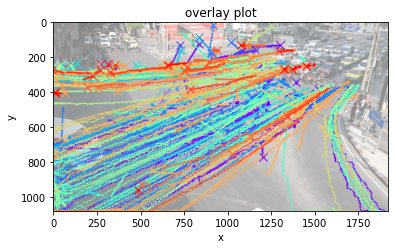

In [23]:
df = pd.read_csv(track_filename)
plotting = csv_to_list(df)
traj_plot(plotting,[])

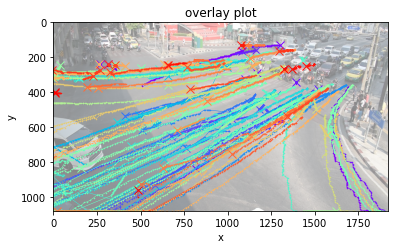

In [24]:
df = pd.read_csv(track_filename)
plotting = csv_to_list_filter(df)
traj_plot(plotting,[])

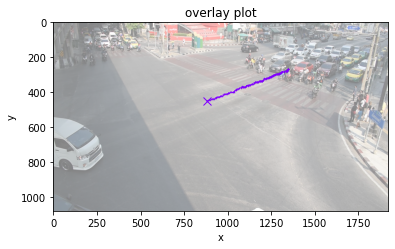

In [27]:
plotting_id = csv_to_list_id(df,[623])
traj_plot(plotting_id,[])

In [26]:
df = pd.read_csv(track_filename)
plotting = csv_to_list(df)
traj_plot_all(plotting)

NameError: name 'traj_plot_all' is not defined

In [ ]:
def get_path_i(df,i):
  sort_id = df.sort_values(["id","frame"])
  max_id = sort_id['id'].max()
  id1 = sort_id[sort_id["id"] == i]
  id1 = id1.reset_index()
  path_point = []
  x_array = []
  y_array = []
  for j in range(0, len(id1)):
    x_center = id1.iloc[j]['x']
    y_center = id1.iloc[j]['y']
    x_array.append(x_center)
    y_array.append(y_center)
    path_point.append((x_center,y_center))
  return path_point, x_array, y_array

path49, x49, y49 = get_path_i(df,49)


In [ ]:
def linear_equation(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return m, b

def y_from_eqn(x,m,b):
    y =  m*x+b 
    return y

m,b = linear_equation(dst_list[10], dst_list[1])
x_range = [dst_list[10][0],dst_list[1][0]]
x_range.sort()
error_path =[]

for i in range(len(x49)):
    x_path = x49[i]
    if x_range[0] <= x_path <= x_range[1]:
        y_path = y49[i]
        y = y_from_eqn(x_path,m,b)
        p_error = abs(y-y_path)
        error_path.append(p_error)
print(error_path)

avg_error = sum(error_path)/len(error_path)
print("average error: " +str(avg_error)+" m" )


[28.42561310827909, 28.72333007402797, 29.020701426310183, 29.280618321383088, 29.540271468734606, 29.799661269613637, 30.05878812445562, 30.31765243288456, 29.305632268671395, 29.269332792829225, 29.124083377771267, 29.160403460481966, 29.26147116304078, 29.33380356732421, 29.433810344667908, 29.4698239578286, 29.505832501158576, 29.604791919191733, 28.77278660084192, 28.77278660084192, 28.77278660084192, 28.77278660084192, 28.77278660084192, 28.705389465267054, 28.63747577357431, 28.63747577357431, 28.63747577357431, 28.63747577357431, 28.87205891422754, 28.84136874101163, 28.87868095531382, 28.9159877338791, 28.88535255067345, 28.96023881190345, 28.96023881190345, 28.92966025751183, 28.967240740045014, 29.004815707448603, 28.974295452521474, 29.01201152013445, 29.049722032267724, 28.981403548466606, 29.057114413973284, 29.094961451694687, 29.026567107287228, 29.102553130794558, 29.140537685641267, 29.110202681707463, 29.14833143527348, 29.14833143527348, 29.156184819973035, 29.19445

In [ ]:
sd_error = np.std(error_path)
print("sd of error: " +str(sd_error) )

sd of error: 0.3358420537328733


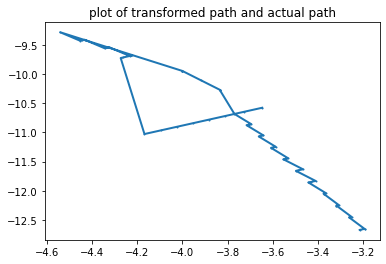

In [ ]:
# plot

#fig, ax = plt.subplots()
#plt.figure(figsize=(15,15))
plt.plot(x49, y49, marker="o", linewidth=2, ms=1)

x = np.linspace(-7,5.5,100)
y = m*x+b
#plt.plot(x, y, '-r')
plt.title("plot of transformed path and actual path")
#plt.grid()
plt.show()


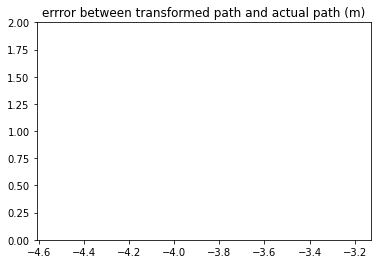

In [ ]:
new_x49 =[]
for x in x49:
    if x_range[0] <= x <= x_range[1]:
        new_x49.append(x)

#plot
plt.scatter(new_x49, error_path, marker='.', linewidths=0.1)
#trend line
z = np.polyfit(new_x49, error_path, 1)
p = np.poly1d(z)
plt.plot(new_x49,p(new_x49),"r--")

plt.ylim([0, 2])
plt.title("errror between transformed path and actual path (m)")
plt.show()
